![header](https://i.ibb.co/Wfkf5NT/Market-Header.png)

# __Market Machine Learning__
#### [TJ Bray](https://www.linkedin.com/in/thomas-tj-bray-24499354/) <br>
*A Flatiron School Capstone Project*
***

### Table of Contents:
- [Overview](#Overview)
    - [Data](#Data)
    - [Business Objective](#Business-Objective)
    - [Methodology](#Methodology)
- [Library Imports](#Library-Imports)
- [Data Imports](#Data_Imports)
- [Data Cleaning and Feature Engineering](#Data-Cleaning-and-Feature-Engineering)
- [Data Selection](#Data-Selection)
- [Price Charts](#Price-Charts)
- [Pre-Processing](#Pre-Processing)
- [Modeling](#Modeling)
    - [Regressions](#Regressions)
        - [Elastic Net](#Elastic-Net)
        - [SVR](#SVR)
        - [Ridge](#Ridge)
    - [Classifiers](#Classifiers)
        - [Logistic Regression](#Logistic-Regression)
        - [Decision Tree](#Decision-Tree)
        - [XGBoost](#XGBoost)
- [Results](#Final-Results)

## Overview
***
Machine learning techniques used for predicting stock prices involve analyzing historical data to forecast future performance. This is done by looking at patterns in the data which includes current and past information and finding the best fit predictive models. Machine learning modeling can be done with a multitude of different algorithms and associated parameters and/or hyperparameters. These predictive models can be used by investors to be make informed investment decisions that will provide them with higher returns while minimizing losses. In recent years, the continued development of machine learning has provided a greater level of model performance for stock price prediction. 

This project seeks to use historical data in order to create models that can predict the price movement of stocks in order to make better investment decisions.

### Data
***
For this project, I will be using stock market data gathered from multiple sources.
- The individual company data is from Kaggle staff member [Paul Mooney's](https://www.kaggle.com/paultimothymooney) [Stock Market Dataset](https://www.kaggle.com/paultimothymooney/stock-market-data). This is updated on a weekly basis. 
- The S&P 500 index data has been gathered from Kaggle Grandmaster [Larxel's](https://www.kaggle.com/andrewmvd) [S&P 500](https://www.kaggle.com/andrewmvd/sp-500-stocks?select=sp500_index.csv) dataset. 
- Macroeconomic data has been sourced from Kaggle user [Calven Ng](https://www.kaggle.com/calven22) and his [USA Key Economic Indicators](https://www.kaggle.com/calven22/usa-key-macroeconomic-indicators) dataset.

As the stock market is constantly trading and providing new information. I have also included API calls using [UniBit](https://unibit.ai/solution). This provides daily trading information on stocks.

### Business Objective
***
This project seeks to create models using different machine learning algoritihms that can predict the price movements of a stock on a given day. Creating returns above a baseline index is wildly valuable and sought after throughout the financial world. 

### Methodology
***
In searching for the best models, I use both regression based and classification based machine learning algorithims. While being able to predict the exact price of a stock on a given day is the Golden Goose, being confident in whether the price will go up or down is prized as well. 

## Library Imports
***
For this project, many of the technical indicators I use are from the [Pandas Technical analysis library](https://github.com/twopirllc/pandas-ta). The library contains over 130+ technical indicators that are frequently used by investors from around the world.

In [48]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, mean_squared_error, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

## Data Imports
***

The following four cells availble to use as API calls. They retrieve my API key and create a function that returns data from an API call using the previously mentioned UniBit API.

Obtaining data for the stock market can be expensive. Due to the profitability this data can create, many companies charge high prices for their data. In a perfect world, I would continuously update my data with daily (or even smaller time frames) API calls. However, because of the price of this data for personal use, I am relying on the Kaggle Datasets for the modeling processes of this project. 

In [2]:
# This is the code used to retreive and return my api key
def get_keys(path):
    with open(path) as f:
        return f.readlines()[0]

In [3]:
# a function to return the historical trading information of a given stock, 
# depending on the interval, start date, and end date.

def get_historical_stock_price(ticker, interval = None, startDate = None, endDate = None):
    url = 'https://api.unibit.ai/v2/stock/historical?'

    ticker_dict = {
        'tickers' : ticker,
        'interval' : interval,
        'startDate' : startDate,
        'endDate' : endDate,
        'selectedFields' : None,
        'dataType':'json',
        'accessKey': get_keys('C:\\Users\\TJ Bray\.secret\\unibit.txt')
    }
    
    response = requests.get(url, params = ticker_dict)
    data = response.json()['result_data'][ticker]
    df = pd.json_normalize(data)
    
    return df

In [4]:
# An API call to retrieve the trading information on Nike from Jan 1, 2021 to Jan 7, 2022

#NKE = get_historical_stock_price('NKE', startDate = '2021-1-1', endDate = '2022-1-7')
#NKE.to_csv('nike.csv')

In [5]:
# Reading in the new information to a CSV for cleaning

#nike = pd.read_csv('nike.csv', index_col = 0)

## Data Cleaning and Feature Engineering
***

### Stock Technical Indicators

***Adjusted Closing Price*** - This is what my regression models attempt to predict and is the basis for my analysis. The closing price of the stock at the end of the day, adjusted for stock splits, dividends, Adjusted closing price is used to show how stock splits, dividends, and other corporate actions, change the value of the stock.  

***Day Direction*** - This is the dependent variable for much of my analysis. Being able to predict which way a stock will move on a given day is the key to making above baseline returns in the market.

**1**. ***Relative Strength Index*** - The Relative Strength Index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes on the stock. RSI exists on a scale between 0 and 100. Measurements above 70 indicate that a stock may be overbought or overvalued by the market. This can be a signal that a pullback is coming. An RSI below 30, can indicate that a stock is currently undervalued by the market and may be primed to increase in price. RSI is calculated using a formula that considers the percentage gains and percentage losses over past periods. The standard to number of periods to use is 14.

**2**. ***Moving Averages*** - Moving averages are simple technical analysis tools that smooth the price movements over a given period of time. Moving averages help filter out noise that short term price movements may cause. They can be used to identify trends in the price and determine support and resistance levels for assets. When asset prices cross a moving average, it can indicate signals for traders of a stronger price movement in the given direction. For this project, I use the 7, 22, 50, and 252 day moving averages. They are the most commonly used averages in technical analysis. The 22 and 252 day averages represent the trading month, and trading year, respectively.
>**a**. Simple Moving Average - The simple moving average is simply the average price of the asset over the last $n$ periods.
<br>**b**. Exponential Moving Average - The exponential moving average is the weighted average price of the asset of the last $n$ periods. This average gives a higher weight to more recent prices.

**3**. ***Crossovers*** -
>**a**. Golden Crossovers - these happen when a shorter term moving average crosses over a longer term one. For the purposes of this project, I have incorported both long-term and short-term crossover. The 7 day ema crossing over the 50 day ema, as well as the 50 day ema crossing over the 252 day ema.
<br>**b**. Death Crossovers - these happen in the inverse. When a short-term moving average crosses below a long-term moving average. This is generally a bad sign for a stock and sign of a downturn to come.

**4**. ***Bollinger Bands*** - Developed by John Bollinger, these bands are a measure of stock volatility over a past number of periods. They measure the standard deviation of the simple moving average of closing price. The generally used periods are 20 periods and 2 standard deviations from the moving average price. When the bands tighten, it signals a period of low volatility and can also alert investor to incoming price movements. When the bands widen, it signals a period of higher volatility and the possible end to the existing trend. When price moves out of a band one way or another, it indicates a strong move in that direction. 

**5**. ***Momentum*** - Momentum is the rate of change of an asset price. A high value for momentum indicates a strong turn in
    # either a positive or negative direction. 

### Marketwide Factors 
In a separate notebook, I meaured macroeconomic factors in order to quantify the overall market sentiment during the given periods. 

**1**. **S&P 500 Data** - I created variables for the overall performance of the S&P 500. This was done to parse out how the market was doing as a whole vs. individual company performance. There is a saying, "rising tides lift all boats", in strong markets, this can cause stock prices to rise even when the company isn't necessarily outperforming their baseline. The specific variables I used are:
>**a**. S&P 500 RSI 
<br>**b**. S&P 500 Moving Averages
<br>**c**. S&P 500 Bollinger Bands

**2**. **United States Macroeconomic Factors** - There are also US economic data factors that attempt to account for wider economic factors. 
>**a**. Personal Savings Rate 
<br>**b**. M2 Money Supply
<br>**c**. Core Consumer Price Index
<br>**d**. Disposable Personal Income
<br>**e**. Treasury Rate
<br>**f**. Federal Funds Rate
<br>**g**. Industrial Production

One problem that arises with the inclusion of the macroeconomic data is periods of time that pass between the reporting of the data. The data is not available with daily time frames. In order to make sure my data lines up with the trading data, I forward filled the macroeconomic data until the day it was reported. While there are generally leaks, rumors, and reports, regarding the release of this data, there are constantly surprises. In future analysis, trying to parse out positive and negative rumors and reports could provide more insight to how these factors affect the market as a whole. 

In [6]:
# This function takes a company ticker symbol, then cleans and adds features to the data.

def create_dataframe(company):
    
    # use the company name to read the csv and reformat the column names
    csv_for_df = f'sp_500_data/{company}.csv'
    df = pd.read_csv(csv_for_df)
    df.columns = [i.lower().replace(' ',"") for i in df.columns]
    
    # Set the date to a datetime format and make it the index of the dataframe.
    df['date'] = pd.to_datetime(df.date, format = '%d-%m-%Y')
    df.set_index('date', inplace = True)
    df.sort_index(inplace = True)
    
    # The direction of the stock price from the trading day.    
    df['day_direction'] = np.where(df['close'] > df['close'].shift(1),1,0)
    
    # Creates a variable for Relative Strength Index (RSI) of a stock. 
    df['rsi'] = ta.rsi(df.close)
    
    # Creates a variable to mark days when the RSI crosses above or below the overbought and oversold
    # thresholds of 70 and 30, respectively.
    df['RSI_overbought_cross'] = np.where((df['rsi'] >= 70) & (df['rsi'].shift(1) < 70),1,0)

    df['RSI_oversold_cross'] = np.where((df['rsi'] <= 30) & (df['rsi'].shift(1) > 30),1,0)
    
    # Marks the days where the RSI is sitting above or below the thresholds.
    df['RSI_overbought'] = np.where(df['rsi'] >= 70,1,0)

    df['RSI_oversold'] = np.where(df['rsi'] <= 30,1,0)
    
    # Moving Average Time Periods
    days = [7,22,50,252]
    
    # The simple moving average (sma) is simply the average price of the asset of the past given number of days.
    for i in days:
        sma_name = f'sma{i}'
        df[sma_name] = ta.sma(df['close'],i)
        
    # The exponential moving average (ema) is weighted so that more recent days are weighed more heavily in the
    # calculation.
    for i in days:
        ema_name = f'ema{i}'
        df[ema_name] = ta.ema(df['close'],i)
    
    # The exponential moving average zone between the daily high and low can paint a picture of how volatile
    # the price of the asset has been over the past given number of days. 
    for i in days:
        zone_name = f'ema{i}zone'
        df[zone_name] = ta.ema(df.high,i) - ta.ema(df.low,i)
    
    # creates a variable for Bollinger Bands
    bbands = ta.bbands(df.close)
    df = df.join(bbands)

    # create Crossover variables
    df['golden_crossover_short'] = np.where((df['ema50'] < df['ema7']) & (df['ema50'].shift(1) > df['ema7'].shift(1)),1,0) 

    df['death_crossover_short'] = np.where((df['ema50'] > df['ema7']) & (df['ema50'].shift(1) < df['ema7'].shift(1)),1,0) 

    df['golden_crossover_long'] = np.where((df['ema252'] < df['ema50']) & (df['ema252'].shift(1) > df['ema50'].shift(1)),1,0) 

    df['death_crossover_long'] = np.where((df['ema252'] > df['ema50']) & (df['ema252'].shift(1) < df['ema50'].shift(1)),1,0) 

    # create a momentum variable
    df['momentum'] = ta.mom(df['close'])
    
    # import macroeconomic factor data
    market_data = pd.read_csv('marketsentiment.csv', index_col = 0)
    
    # Joining the market DataFrame to the individual companies trading information and dropping the dates that
    # are not in both. 
    df = df.join(market_data, rsuffix = '_macro')
    
    df.dropna(inplace = True)
    
    return df

## Data Selection
***
In order to remove selection bias as much as possible from my analysis, I created a loop that goes through the list of S&P 500 companies and returns a random list of companies.

In [7]:
# gets a list of files in the S&P 500 data folder.
files = [f for f in listdir('.\sp_500_data')]

# creates a list of company names from the list of files.
companies = []
for i in files:
    company = i.split('.')[0]
    companies.append(company)

In [8]:
# creates a list of x number of random companies to process and analyze
test_companies = np.random.choice(companies, 75, replace = False)
test_companies

array(['ES', 'ABC', 'TRAUF', 'INTH', 'REG', 'LOW', 'COO', 'AMP', 'HOLX',
       'LYB', 'MSI', 'AVB', 'ESS', 'CSCO', 'SHW', 'CDNS', 'DOV', 'SPG',
       'TSCO', 'WY', 'AIZ', 'MGM', 'PNR', 'TAP', 'FIS', 'CHRW', 'NOXL',
       'ED', 'IPGP', 'FAST', 'NEOG', 'CTQ', 'ALLE', 'VRSK', 'LRCX', 'NVR',
       'CFG', 'UNP', 'FRC', 'IDXX', 'MHK', 'ALGN', 'ANTM', 'VRSN', 'CNC',
       'MCD', 'AMAT', 'RE', 'KEY', 'SWK', 'RSG', 'RMD', 'CTAS', 'GPC',
       'HST', 'T', 'ANET', 'NRG', 'BMRA', 'MET', 'FANG', 'MDLZ', 'AAL',
       'WRK', 'PEP', 'TYL', 'WYNN', 'HD', 'ARE', 'FLT', 'AEP', 'SEGXF',
       'JPM', 'ROP', 'HSIC'], dtype='<U11')

In [9]:
#a loop that creates a formatted DataFrame for the company and saves it
#for c in test_companies:
#    df = create_dataframe(c)
#    csv_name = f'FormattedData/{c}_formatted.csv'
#    df.to_csv(csv_name)

## Price Charts
***

In [10]:
# This function takes the DataFrame of a companies trading history and the company name in order to plot
# the movement of the adjusted closing price and simple moving averages.

def plot_price(df, company, start_date = '6-1-2021', end_date = '12-31-2021'):
    
    df.index = pd.to_datetime(df.index)
    
    title = f'{company} Stock Price since {start_date}'

    plotdata = df[(df.index >= start_date) & (df.index <= end_date)]
    fig, ax = plt.subplots(figsize = (24,12))
    ax.plot(plotdata.close, linewidth = 3.8)
    ax.plot(plotdata.sma7)
    ax.plot(plotdata.sma22)
    ax.plot(plotdata.sma252)
    ax.yaxis.set_major_formatter('${x:1,.2f}')
    ax.legend(['Adjusted Closing Price', 'Trading Week Moving Average', 'Trading Month Moving Average', 'Trading Year Moving Average'],
             fontsize = 'x-large', edgecolor = '1')
    ax.set_title(title, fontsize = '30', pad = 17)
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')

    plt.show()

In [11]:
# A function that plots the upper and lower Bollinger Bands along with the adjusted closing price.

def plot_bbands(df, company):
    
    df.index = pd.to_datetime(df.index)
        
    date = '1-1-2020'
    title1 = f'{company} Bollinger Band Width since {date}'
    title2 = f'{company} RSI since {date}'
    plotdata = df[df.index >= date]

    fig, (ax1, ax2) = plt.subplots(2, figsize = (24,20), sharex = True, gridspec_kw = {'height_ratios': [2,1]})
    ax1.plot(plotdata.close, linewidth = 4)
    ax1.fill_between(plotdata.index, plotdata['BBL_5_2.0'], plotdata['BBU_5_2.0'], facecolor = 'blue', alpha = .1)
    ax1.yaxis.set_major_formatter('${x:1,.2f}')
    ax1.legend(['Adjusted Closing Price', 'Bollinger Band Width'],
             fontsize = 'x-large', edgecolor = '1')
    ax1.set_title(title1, fontsize = '35', pad = 18)

    ax2.plot(plotdata.rsi, linewidth = 2)
    ax2.hlines(y=70, linestyle = "--", xmin =plotdata.index.min(), xmax =plotdata.index.max(), alpha = 1, color = 'red')
    ax2.hlines(y=50, linestyle = "--", xmin =plotdata.index.min(), xmax =plotdata.index.max(), alpha = .5, color = 'blue')
    ax2.hlines(y=30, linestyle = "--", xmin =plotdata.index.min(), xmax =plotdata.index.max(), alpha = 1, color = 'green')
    ax2.legend(['Relative Strength Index'],
             fontsize = 'x-large', edgecolor = '1')
    ax2.set_title(title2, fontsize = '35', pad = 18)

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()

In [12]:
AMD = pd.read_csv('FormattedData/AMD_formatted.csv', index_col = 0)

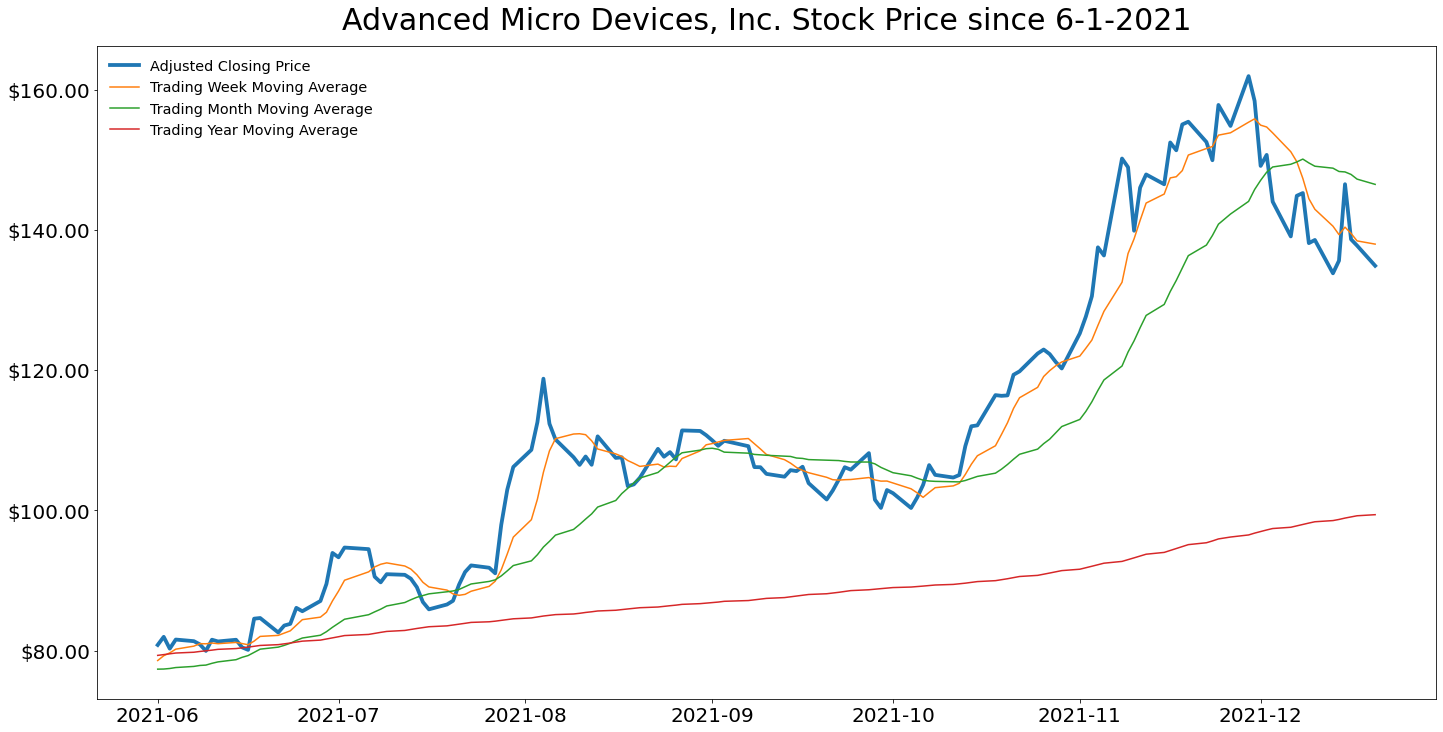

In [13]:
plot_price(AMD, 'Advanced Micro Devices, Inc.')

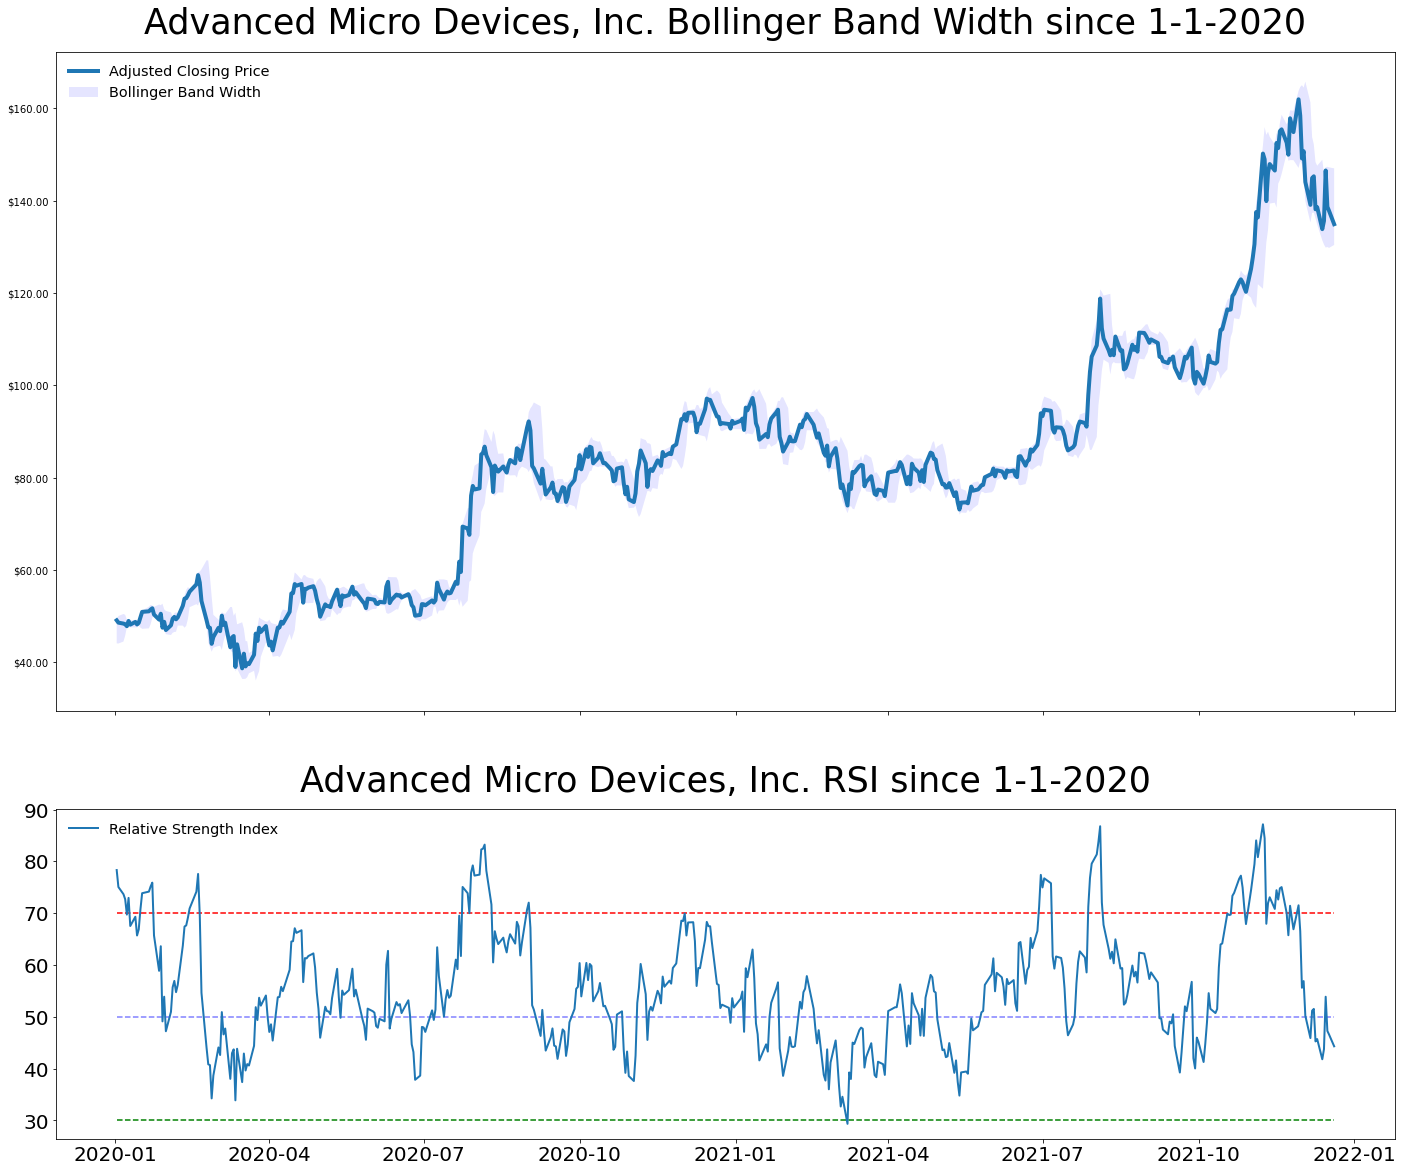

In [14]:
plot_bbands(AMD, 'Advanced Micro Devices, Inc.')

## Pre-Processing
***

### Removing Correlations
This function is only called within the next function, *preprocess_data()* in order to avoid dropping the target variables.

In [15]:
def remove_corrs(df):
    
    # create a DataFrame with all the of the correlation coefficients, and then stack the pairings.
    corrs = df.corr().stack().reset_index()
    corrs.columns = ['1','2','R2']
    # create a temoporary DataFrame that contains all the pairs of variables that have a correlation
    # between .8 and .999. Because the .corr() method returns the pairings in both directions, I only
    # look at half of the cells because of duplicates.
    temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
    correlations = temp[temp.index % 2 == 0]
    
    # look at how many times each variable shows up in the correlation column
    corr_index = correlations['1'].value_counts().index
    # delete the first 90% of the variables. This generally removes the columns that are most correlated with the others. 
    to_drop = round(len(corr_index)*.9)
    
    df2 = df.drop(corr_index[:to_drop], axis = 1)
    
    return df2

### Train Test Split and Scaling Data

In [16]:
def preprocess_data(df, target_var = 'close'):
    
    df.index = pd.to_datetime(df.index)
    
    # Here, I shift all the independent variables back one day in order to make sure there is
    # no data leakage. Because we're trying to predict closing price, we can't know many of
    # things that happen throughout the day we're trying to predict.
    X = df.shift(1).dropna()
    
    # This is the function described above.
    X_data = remove_corrs(X)

    # Because I am running a regression, I can use a continuous variable as my dependent variable.
    # Ideally, my algorithim can predict the closing price at the end of the day with accuracy.
    y = df[target_var].iloc[1:]
    
    # Do a train test split with the first 80% of the data being the training set and the last 20%
    # as the testing set.
    train_num = round(len(X)*.8)
    test_num = round(len(X)*.2)

    X_train = X_data.iloc[:train_num]
    X_test = X_data.iloc[-test_num:]
    y_train = y.iloc[:train_num]
    y_test = y.iloc[-test_num:]
    
    # Because I am doing distance based regressions, I need to scale the data so that variables with
    # higher absolute values don't dominate the metrics.
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

## Modeling
***

In creating models, I tried many different things. My first attempt was using regular least squares OLS regression, however, I experienced a high standard deviation in the r-squared of the models, as well as a high condition condition number throughout the different models. 

This did not allow me to use [statsmodels'](https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html) Rolling OLS regressions either. In a perfect world, I would be able to use Rolling Regressions for all of the following models to be able to have models that only need to predict for a singular day.

### Baseline
***

For the purposes of this project, my baseline model is going to be that the stock will continue to go in the same direction each day. Therefore, if it goes up on most days throughout the training set, the baseline will predict that it continues to go up. If the inverse is true, the baseline model will predict the stock to continue to go down. 

In [17]:
# gets a list of files in the S&P 500 data folder.
files = [f for f in listdir('.\FormattedData')]

#remove the ipynb checkpoint file
files.pop(0)

# creates a list of company names from the list of files.
companies = []
for i in files:
    company = i.split('_')[0]
    companies.append(company)

baseline = []

for c in companies:
    df = create_dataframe(c)
    df_train = df.iloc[:(round(len(df)*.8))]
    df_test = df.iloc[-(round(len(df)*.2)):]
    dir_pct = df_train['day_direction'].value_counts(normalize = True)
    if dir_pct[1] > .5:
        test_pct = df_test['day_direction'].value_counts(normalize = True)[1]
        baseline.append([c, test_pct])
    else:
        test_pct = df_test['day_direction'].value_counts(normalize = True)[0]
        baseline.append([c, test_pct])

In [18]:
baseline_results = pd.DataFrame(baseline, columns = ['company', 'baseline'])
baseline_results.sort_values('baseline', ascending = False).head()

,company,baseline
44,FRMC,0.995050
65,MRCR,0.931111
69,NTRR,0.657778
78,RIBT,0.613333
50,HPQ,0.577778


### Regressions
***

#### Elastic Net

In [19]:
FDX = pd.read_csv('FormattedData/FDX_formatted.csv', index_col = 0)

X_train, X_test, y_train, y_test = preprocess_data(FDX)

In [20]:
def EN_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'l1_ratio': [.01,.25,.5,.75,1],
    'alpha': [.01,.25,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    en = ElasticNet(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=en, param_grid=grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_hat_train = gs.predict(X_train)
    y_hat_test = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error').mean()

    # Score the train and test sets.
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    
    print(f'Train RMSE: {train_score}')
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    print(f'Test RMSE: {test_score}')

    # Create a DataFrame that has the predictions for the given days of the train set.
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), FDX.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    # Compare the direction of the predicted value with what actually happened on the given day.
    preds_train['direction'] = np.where(preds_train.predictions > preds_train.close.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    # Create a DataFrame that has the predictions for the given days of the test set.
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), FDX.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    # Compare the direction of the predicted value with what actually happend on the given day. 
    preds_test['direction'] = np.where(preds_test.predictions > preds_test.close.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)

    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')
    
    normality_score = normaltest(y_hat_train - y_train)[1]
    print(f'Normality score: {normality_score}')

    results = ['Elastic Net', train_score, cv_results, test_score, train_accuracy[1], test_accuracy[1], normality_score]
    
    return results

Train RMSE: 21.747770711675624
Mean Cross-Val Score: -45.99986756540553
Test RMSE: 78.0120890677155
Train accuracy: 0.5005561735261401
Test accuracy: 0.54


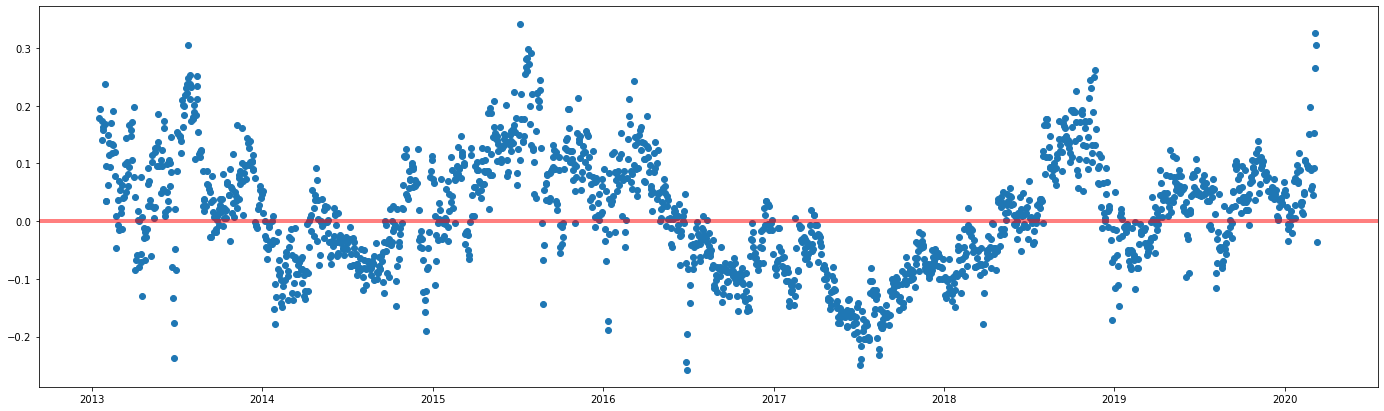

In [50]:
fig, ax = plt.subplots(figsize = (24,7))
plot_x = y_train.index
plot_y = (y_hat_train - y_train)/y_train
plt.scatter(plot_x,plot_y)
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

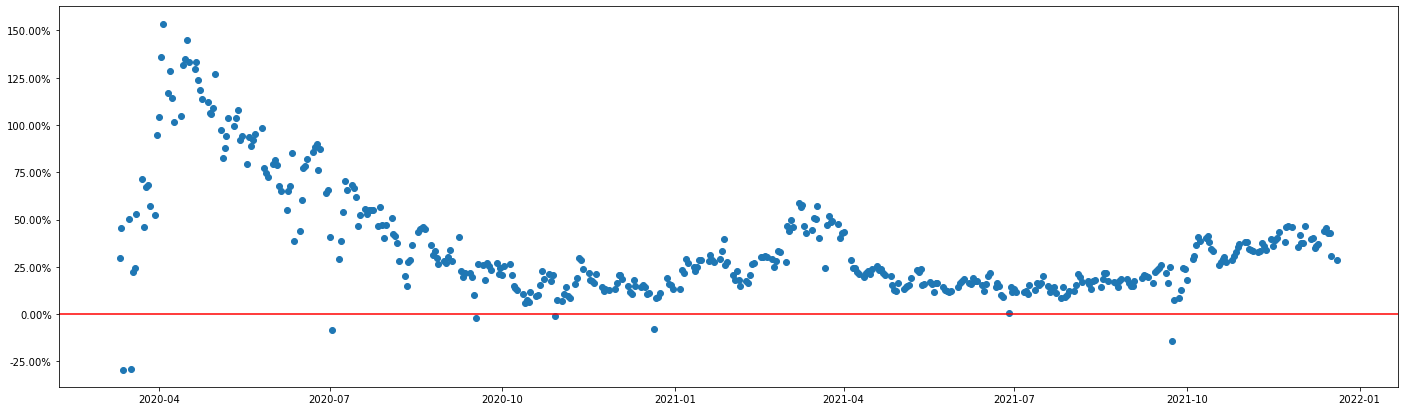

In [22]:
fig2, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_test.index, (y_hat_test - y_test)/y_test)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = 1, color = 'red');

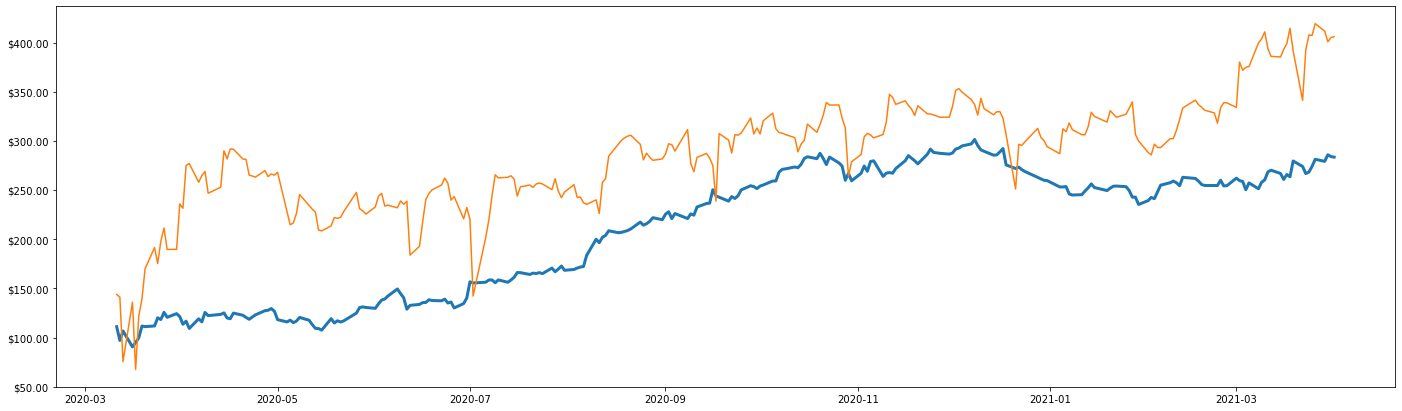

In [24]:
fig3, ax = plt.subplots(figsize = (24,7))
fig3_data = preds_test[(preds_test.index >= '1-1-2020') & (preds_test.index <= '4-1-2021')]
ax.plot(fig3_data.close, linewidth = 3.0)
ax.plot(fig3_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');

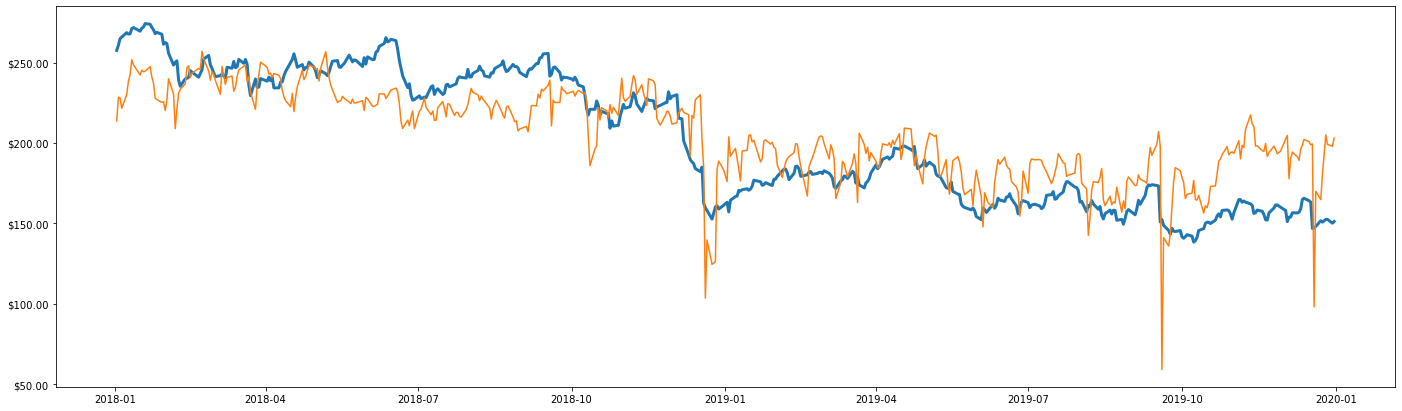

In [25]:
fig4, ax = plt.subplots(figsize = (24,7))
fig4_data = preds_train[(preds_train.index >= '1-1-2018') & (preds_train.index <= '1-1-2020')]
ax.plot(fig4_data.close, linewidth = 3.0)
ax.plot(fig4_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');

#### SVR

In [26]:
KRA = pd.read_csv('FormattedData/KRA_formatted.csv', index_col = 0)

X_train, X_test, y_train, y_test = preprocess_data(KRA)

In [27]:
def SVR_test(X_train, X_test, y_train, y_test, cv=5):
    
    svr = LinearSVR(random_state = 42, max_iter = 10e4)
    svrmodel = svr.fit(X_train, y_train)
    
    train_score = svr.score(X_train, y_train)
    y_hat_train = svr.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    train_cv_score = cross_val_score(svrmodel, X_train, y_train, scoring = 'neg_root_mean_squared_error').mean()
    
    test_score = svr.score(X_test, y_test)
    y_hat_test = svr.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), KRA.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.close.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), KRA.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.close.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)
    
    print(f'Train RMSE : {train_rmse}')
    print(f'Mean Train Cross-Validation RMSE: {train_cv_score}')
    print(f'Test RMSE : {test_rmse}')
    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')

    normality_score = normaltest(y_hat_train - y_train)[1]
    print(f'Normality score: {normality_score}')

    results = ['SVR', train_score, train_cv_score, test_score, train_accuracy[1], test_accuracy[1], normality_score]
    
    return results

Train RMSE : 10.748908859231062
Mean Train Cross-Validation RMSE: -11.894383579144186
Test RMSE : 20.025317896333704
Train accuracy: 0.4860956618464961
Test accuracy: 0.5533333333333333


#### Ridge

In [46]:
MGM = pd.read_csv('FormattedData/MGM_formatted.csv', index_col = 0)

X_train, X_test, y_train, y_test = preprocess_data(MGM)

In [53]:
def Ridge_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'alpha': [.01, .05, .1,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    ridge = Ridge(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=ridge, param_grid=grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    ridge_params = gs.best_params_
    
    # Create prediction variable using test data
    y_hat_train = gs.predict(X_train)
    y_hat_test = gs.predict(X_test)

    # Run cross-validate score with cv folds from function parameter
    train_cv_score = cross_val_score(gs, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error').mean()
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), MGM.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.close.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), MGM.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.close.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)
    
    print(f'Train RMSE : {train_rmse}')
    print(f'Mean Train Cross-Validation RMSE: {train_cv_score}')
    print(f'Test RMSE : {test_rmse}')
    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')
 
    normality_score = normaltest(y_hat_train - y_train)[1]
    print(f'Normality score: {normality_score}')

    results = ['Ridge', train_rmse, train_cv_score, test_rmse, train_accuracy[1], test_accuracy[1], normality_score]
    
    return results

In [54]:
MGM_results = Ridge_test(X_train, X_test, y_train, y_test)

Train RMSE : 2.4428902636128194
Mean Train Cross-Validation RMSE: -3.9141046080098776
Test RMSE : 17.038558651743028
Train accuracy: 0.517797552836485
Test accuracy: 0.4866666666666667
Normality score: 3.3873564156805414e-06


#### Final Regression Results

In [30]:
regression_results = pd.read_csv('normregressionresults.csv', index_col = 0)
regression_results.reset_index(inplace = True, drop = True)

In [31]:
regression_results.sort_values('Test Accuracy', ascending = False)

,Model Type,Train RMSE,Cross-Val RMSE,Test RMSE,Train Accuracy,Test Accuracy,Normality of Residuals,company
90,Elastic Net,-12.145711,-119.740648,-4.253935e+01,0.477197,0.657778,0.000000e+00,NTRR
92,Ridge,11.895724,-653.591790,5.351769e+01,0.487208,0.657778,0.000000e+00,NTRR
3,Elastic Net,-2.473025,-8.363451,-2.165170e+01,0.525028,0.613333,5.206300e-21,RIBT
127,SVR,-929.967952,-109.978774,-5.339874e+01,0.517241,0.573333,0.000000e+00,HPQ
42,Elastic Net,-25.109235,-52.210233,-4.529536e+01,0.505006,0.566667,5.511223e-08,FDX
...,...,...,...,...,...,...,...,...
28,SVR,-46.878859,-137.039490,-6.603128e+00,0.533370,0.453333,0.000000e+00,EW
46,SVR,-0.202259,-45.392088,-1.532402e+00,0.507230,0.451111,8.629298e-235,ADSK
112,SVR,0.306195,-33.477447,-5.709233e-01,0.499444,0.448889,0.000000e+00,FRC
34,SVR,-3.386553,-26.173303,-1.953338e+01,0.477197,0.446667,0.000000e+00,ROL


### Classifiers
***

#### Logistic Regression

In [32]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv,
                      scoring='accuracy', n_jobs = -1, error_score = 0)
    gs.fit(X_train, y_train)
        
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()

    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Accuracy: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)
    
    results = ['logistic regression', train_score, cv_results, test_score]
    
    return results

In [33]:
BWA = pd.read_csv('FormattedData/BWA_formatted.csv', index_col = 0)
X_train, X_test, y_train, y_test = preprocess_data(BWA, 'day_direction')

Train Mean Accuracy: 0.5461624026696329
Mean Cross-Val Accuracy: 0.4966774992262457
Test Mean Accuracy: 0.5044444444444445


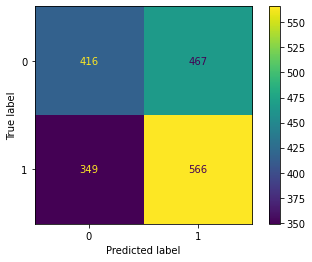

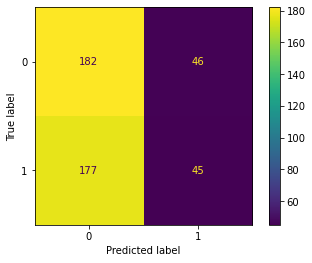

In [34]:
BWA_logreg = logreg(X_train, X_test, y_train, y_test)

#### Decision Tree

In [35]:
def dtree(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,10,15],
    'min_samples_split': [2,8,10,15],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Decision Tree model for GridSearch
    grid_dt = DecisionTreeClassifier()
    grid_dt.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_dt, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)

    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()

    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    
    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Accuracy: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)
    
    results = ['decision tree', train_score, cv_results, test_score]
    
    return results

In [36]:
HES = pd.read_csv('FormattedData/HES_formatted.csv', index_col = 0)
X_train, X_test, y_train, y_test = preprocess_data(HES, 'day_direction')

Train Mean Accuracy: 0.7041156840934372
Mean Cross-Val Accuracy: 0.49221912720519967
Test Mean Accuracy: 0.5155555555555555


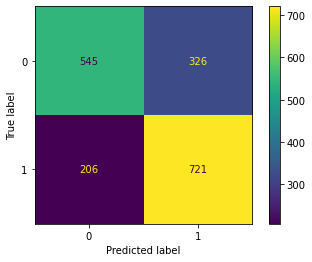

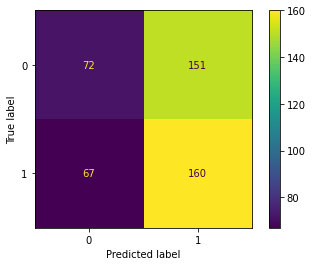

In [37]:
HES_dtree = dtree(X_train, X_test, y_train, y_test)

#### XGBoost

In [38]:
def xgboost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'learning_rate': [.01,.05,.1,.5,1],
    'max_depth': [4],
    'min_child_weight': [3],
    'subsample': [1],
    'n_estimators': [100,500]}
    
    # Instantiate & fit XGClassifier
    xgb = XGBClassifier(verbosity=0, random_state=42)
    #xgb.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=xgb, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()

    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Score: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')

    
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);
    
    results = ['xgboost', train_score, cv_results, test_score]
    
    return results

In [39]:
ALK = pd.read_csv('FormattedData/ALK_formatted.csv', index_col = 0)
X_train, X_test, y_train, y_test = preprocess_data(ALK, 'day_direction')

Train Mean Accuracy: 0.6863181312569522
Mean Cross-Val Score: 0.5039074589910244
Test Mean Accuracy: 0.49333333333333335


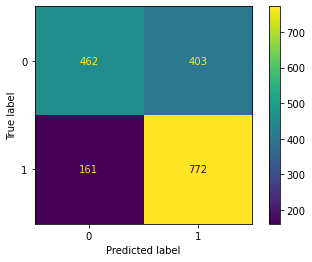

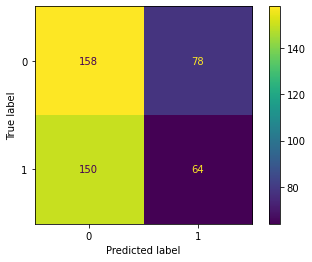

In [40]:
ALK_xgboost = xgboost(X_train, X_test, y_train, y_test)

#### Final Classifier Results

In [41]:
classifier_results = pd.read_csv('ClassifierResults.csv')
classifier_results.sort_values('Test Accuracy', ascending = False)

,Model Type,Train Accuracy,Cross Val Accuracy,Test Accuracy,company
105,xgboost,0.729143,0.571162,0.660000,NTRR
65,logistic regression,0.608454,0.608454,0.657778,NTRR
25,decision tree,0.632369,0.583938,0.646667,NTRR
66,logistic regression,0.537264,0.537264,0.571111,LOW
101,xgboost,0.672414,0.482201,0.564444,HOLX
...,...,...,...,...,...
26,decision tree,0.558398,0.493310,0.453333,LOW
3,decision tree,0.711902,0.528361,0.453333,NI
13,decision tree,0.854839,0.506685,0.451111,NVR
44,logistic regression,0.556730,0.528929,0.451111,TTWO


## Results
***

For my final results, I compare my model test accuracy to the baseline accuracy. 

In [42]:
temp = pd.concat([regression_results, classifier_results], axis = 0)
final_results = temp.merge(baseline_results)
final_results['above_baseline'] = final_results['Test Accuracy'] - final_results['baseline']

In [43]:
final_results[['company', 'Model Type', 'Test Accuracy', 'baseline', 'above_baseline']].sort_values('above_baseline', ascending = False)

,company,Model Type,Test Accuracy,baseline,above_baseline
290,ALK,xgboost,0.531111,0.475556,0.055556
230,HOLX,xgboost,0.564444,0.517778,0.046667
100,BWA,logistic regression,0.537778,0.493333,0.044444
190,KRA,SVR,0.544444,0.500000,0.044444
29,MGM,Ridge,0.517778,0.477778,0.040000
...,...,...,...,...,...
172,FRC,SVR,0.448889,0.560000,-0.111111
93,LOW,decision tree,0.453333,0.571111,-0.117778
175,FRC,logistic regression,0.435556,0.560000,-0.124444
136,NTRR,SVR,0.477778,0.657778,-0.180000


In [44]:
final_results.groupby('Model Type').mean()

,Train RMSE,Cross-Val RMSE,Test RMSE,Train Accuracy,Test Accuracy,Normality of Residuals,Cross Val Accuracy,baseline,above_baseline
Model Type,,,,,,,,,
Elastic Net,-6.058986,-13.077832,-2.465353e+01,0.510015,0.515506,0.011944,NaN,0.530624,-0.015118
Ridge,6.617988,-23.050653,2.645526e+01,0.509607,0.508522,0.002575,NaN,0.530624,-0.022102
SVR,-31.496718,-72.752036,-1.120753e+08,0.509540,0.505467,0.010036,NaN,0.530624,-0.025157
decision tree,NaN,NaN,NaN,0.675136,0.501347,NaN,0.500028,0.529607,-0.028260
logistic regression,NaN,NaN,NaN,0.537738,0.522316,NaN,0.529903,0.529607,-0.007291
xgboost,NaN,NaN,NaN,0.833802,0.508242,NaN,0.489711,0.529607,-0.021365


## Conclusions and Next Steps